<div style="text-align: center;">
  <img src="../../../assets/Cover.png" alt="WTF-Agents cover">
</div>

上一节：**[Messages](../A02-Messages/Messages.ipynb)**


### 章节介绍



为了快速认识智能体概念，我们在 **[HelloWorld](../A01-HelloWorld/HelloWorld.ipynb)** 实例中创建了一个智能体，并使用一个工具函数来调用。但并没有解释其中的参数详情，本节内容我们深入智能体内部，了解智能体的参数的具体意义以及创建一个智能体的基本流程

还是以上一个智能体为例，我们先看看智能体的参数参数设置：

### 1. 智能体参数解释

In [ ]:
import os
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient  # autogen_ext 是 autogen extension包，提供了对诸多模型的支持。

# 定义一个模型客户端。也可以使用其他实现了 `ChatCompletionClient` 接口的模型客户端。
model_client = OpenAIChatCompletionClient(
    model="gpt-4.1",
    api_key=os.getenv("OPENAI_API_KEY"),
)

# 定义一个工具函数，让智能体调用
async def hello_world(name: str) -> str:
    """
    A simple tool that returns a greeting message.
    :param name: The name of the person to greet.

    """
    return f"Hello {name}~ Welcome to WTF-Agent!"


# 定义一个 AssistantAgent，并启用模型、工具、系统消息和反射。
agent = AssistantAgent(
    name="Receptionist",  # The name of the agent.
    model_client=model_client,
    description="A friendly receptionist agent that can greet people.",
    tools=[hello_world],
    system_message="You are a warm receptionist. Please use the tools to help your friends.",
    reflect_on_tool_use=True,
    model_client_stream=True,  # Enable streaming tokens from the model client.
)


`AssistantAgent`是一个用于原型设计和教育目的的通用代理,它继承了`BaseChatAgent`类，并提供了一些基本的功能和参数设置。

`name` : 是该智能体的唯一名称，用于和其他智能体区分。

`model_client` : 是一个模型客户端，用于与语言模型进行交互。它可以是一个预定义的模型客户端，也可以是自定义的模型客户端。

`description` : 是对智能体的描述，帮助用户以及其余智能体理解此智能体的功能和用途（⚠️注意，这里的描述不是Agent的系统的提示词，而是智能体的描述，类似于产品说明书）。

`tools` : 是一个工具列表（列表中为方法的名称），智能体可以使用这些工具来完成任务。工具可以是预定义的，也可以是自定义的。

`system_message` : 是智能体的系统系统提示词，用于定义智能体的行为和功能，是Agent之间相互区别的关键。

`run` : 该方法根据字符串任务或消息列表运行智能体，并返回 `TaskResult` 。智能体应保持状态，调用此方法时应传入新消息而非完整历史记录。

`reflect_on_tool_use` : 该方法在工具使用后调用，允许智能体反思其工具使用情况。


📌 如果智能运行过程中没有工具调用的情况

- 如果模型只是输出普通的文本回复（没有调用任何工具），那么这个回复会直接被封装成一个 `TextMessage` 或者 `StructuredMessage`（如果启用了结构化输出）。
- 这个消息会被放在 `Response.chat_message` 中返回。


---

📌如果智能体运行过程中有工具调用的情况

    1️⃣ 情况一：`reflect_on_tool_use=False`


- 如果设置了 `reflect_on_tool_use=False`，工具调用执行完之后，结果不会再次让模型进行推理/总结。
- 而是将工具调用和结果以 `ToolCallSummaryMessage` 的形式直接返回。
- 我们可以通过 `tool_call_summary_format` 来自定义这个摘要信息的内容格式。

    2️⃣ 情况二：`reflect_on_tool_use=True`

- 如果设置为 `True`，表示希望模型在看到工具调用的结果后，再做一次推理，生成最终的自然语言回复。
- 这样用户就能看到更“智能”的结果，而不是原始的工具调用数据。
- 最终结果仍封装为 `TextMessage` 或 `StructuredMessage` 返回。

    3️⃣ 默认值说明

- 如果我们设置了 `output_content_type`（比如要求输出 JSON 格式内容），则默认启用 `reflect_on_tool_use=True`。
- 如果没有设置 `output_content_type`，则默认不启用反思（即 `reflect_on_tool_use=False`）。

---

📌 多个工具调用的处理方式


- 如果模型一次性返回了多个工具调用，默认情况下这些工具调用会**并发执行**。
- 如果你不希望它们并发执行（比如想按顺序一个一个调用），你需要配置对应的模型客户端。
- 比如对于 OpenAI 的客户端，可以设置参数：`parallel_tool_calls=False`。

📌 总结一下整体逻辑流程图


```
模型生成回复
│
├── 没有工具调用 → 直接返回 TextMessage / StructuredMessage
│
└── 有工具调用
    │
    ├── reflect_on_tool_use=False → 返回 ToolCallSummaryMessage
    │
    └── reflect_on_tool_use=True → 执行工具 + 模型再推理 → 返回 TextMessage / StructuredMessage
        │
        └── 多个工具调用 → 默认并发执行（可关闭）

```
使用`reflect_on_tool_use=True`会将工具调用的结果再次传递给模型进行推理，这样可以生成更有利于理解的回复，但同时也会增加延迟和成本。


`model_client_stream` : 是一个布尔参数，用于控制模型客户端是否启用流式输出模式。

**流式输出 vs 非流式输出**

非流式输出（model_client_stream=False，默认值）

```用户输入 → 模型处理 → 等待完整响应 → 一次性返回完整结果```

用户需要等待模型生成完整的回复后才能看到结果,类似于传统的请求-响应模式

流式输出（model_client_stream=True）

```用户输入 → 模型处理 → 逐步返回文本片段 → 实时显示生成过程```

模型生成的文本会以小块（chunks）的形式实时传输

用户可以看到文本逐字逐句地出现，类似于 ChatGPT 的打字效果


### 2. 非流式响应

接下来我们调用 `run()` 方法会返回一个 TaskResult 对象，其 messages 属性包含消息列表，该属性既存储代理的"思考过程"也包含最终响应

⚠️需要注意的是， `run()` 会更新代理的内部状态——它会将消息添加到代理的消息历史记录中。我们也可以不传入任务直接调用 `run()` ，让代理基于当前状态生成响应。

In [ ]:
# 非流式响应
result = await agent.run(task="Hey~ I am Xiaobang")
print(result.messages)

[TextMessage(source='user', models_usage=None, metadata={}, content='Hey~ I am Xiaobang', type='TextMessage'), ToolCallRequestEvent(source='Receptionist', models_usage=RequestUsage(prompt_tokens=0, completion_tokens=0), metadata={}, content=[FunctionCall(id='call_Rk1yXdACFC0WwSFaOLvVJiec', arguments='{"name":"Xiaobang"}', name='hello_world')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='Receptionist', models_usage=None, metadata={}, content=[FunctionExecutionResult(content='Hello Xiaobang~ Welcome to WTF-Agent!', name='hello_world', call_id='call_Rk1yXdACFC0WwSFaOLvVJiec', is_error=False)], type='ToolCallExecutionEvent'), TextMessage(source='Receptionist', models_usage=RequestUsage(prompt_tokens=0, completion_tokens=0), metadata={}, content='Hello again, Xiaobang~ It’s great to see you! How can I help you today?', type='TextMessage')]


将输出内容格式化解读，内容如下：

```python

result.messages = [
    
    # 📝 消息1: 用户输入消息
    TextMessage(
        source='user',
        models_usage=None,
        metadata={},
        content='Hey~ I am Xiaobang',
        type='TextMessage'
    ),
    
    # 🛠️ 消息2: 工具调用请求事件
    ToolCallRequestEvent(
        source='Receptionist',
        models_usage=RequestUsage(prompt_tokens=0, completion_tokens=0),
        metadata={},
        content=[
            FunctionCall(
                id='call_g5YgtvmWPsHYpw1RaYMH0oAm',
                arguments='{"name":"Xiaobang"}',  # 传递给工具的参数
                name='hello_world'  # 调用的工具函数名
            )
        ],
        type='ToolCallRequestEvent'
    ),
    
    # ⚡ 消息3: 工具执行结果事件
    ToolCallExecutionEvent(
        source='Receptionist',
        models_usage=None,
        metadata={},
        content=[
            FunctionExecutionResult(
                content='Hello Xiaobang~ Welcome to WTF-Agent!',  # 工具返回的结果
                name='hello_world',  # 执行的工具名称
                call_id='call_g5YgtvmWPsHYpw1RaYMH0oAm',  # 与请求对应的ID
                is_error=False  # 执行成功，无错误
            )
        ],
        type='ToolCallExecutionEvent'
    ),
    
    # 💬 消息4: 智能体最终回复 (经过反思处理)
    TextMessage(
        source='Receptionist',
        models_usage=RequestUsage(prompt_tokens=0, completion_tokens=0),
        metadata={},
        content='Hello Xiaobang~ Welcome! How can I assist you today?',  # 智能体基于工具结果的自然回复
        type='TextMessage'
    )
]

```

### 3. 流式响应

我们还可以使用 `run_stream()` 方法在代理生成每条消息时进行流式传输，并通过 `Console` 将消息实时打印到控制台。`run_stream()` 方法返回一个异步生成器，该生成器会依次生成代理产生的每条消息，最后一项为 `TaskResult` 。

In [5]:
# 流式响应
async def main() -> None:
    await Console(
        # 启动智能体的流式处理模式
        agent.run_stream(task="Hey~ I am Xiaobang"),
         output_stats=True # 允许状态打印，启用统计信息显示
         ) 
    # 关闭与模型客户端的连接，释放网络资源，避免内存泄漏
    await model_client.close()


# NOTE: if running this inside a Python script you'll need to use asyncio.run(main()).
await main()


---------- TextMessage (user) ----------
Hey~ I am Xiaobang
---------- ToolCallRequestEvent (Receptionist) ----------
[FunctionCall(id='call_9Yr55DkY6W7cxHm4NBaenzsP', arguments='{"name":"Xiaobang"}', name='hello_world')]
[Prompt tokens: 0, Completion tokens: 0]
---------- ToolCallExecutionEvent (Receptionist) ----------
[FunctionExecutionResult(content='Hello Xiaobang~ Welcome to WTF-Agent!', name='hello_world', call_id='call_9Yr55DkY6W7cxHm4NBaenzsP', is_error=False)]
---------- ModelClientStreamingChunkEvent (Receptionist) ----------
Hello Xiaobang~ Welcome back! Let me know how I can assist you today.
[Prompt tokens: 0, Completion tokens: 0]
---------- Summary ----------
Number of messages: 4
Finish reason: None
Total prompt tokens: 0
Total completion tokens: 0
Duration: 2.97 seconds


### 4. 多模态输入


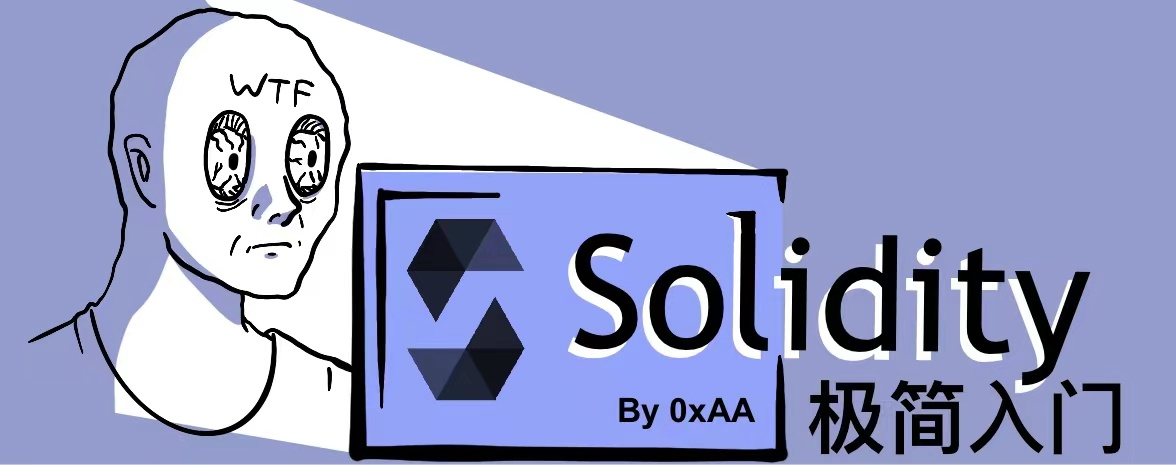

In [ ]:
### 多模态输入

from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://github.com/ShuxunoO/WTF-Agents/raw/main/assets/Cover_2.png").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img
